In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.6.0+cu124


In [2]:
import torch

## Attention Before Self-Attention (Transformers)

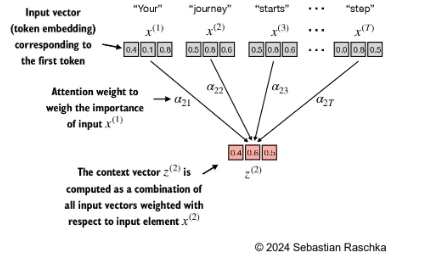

Suppose we are given an input sequence $x^{(1)}$ to $x^{(T)}$
- The input is a text (for example, a sentence like "Your journey starts with one step") that has already been converted into token embeddings like following
- For instance, $x^{(1)}$ is a d-dimensional vector representing the word "Your", and so forth

**Goal**: compute context vectors $z^{(i)}$ for each input sequence element $x^{(i)}$ in $x^{(1)}$ to $x^{(T)}$ (where $ z $ and $ x $ have the same dimension)

In [3]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

# each row represents a word and each column represents an embedding dimension, so 6 X 3

- here training examples are represented as rows and features values as columns

**Step 1** : compute unnormalized attention scores $ \omega $

Ex : for second input token as the query, $ q^{(2)} = x^{(2)} $

- $ \omega_{21} = x^{(1)}q^{(2)T} $
- $ \omega_{22} = x^{(2)}q^{(2)T} $
- $ \omega_{23} = x^{(3)}q^{(2)T} $
- ...
- - $ \omega_{2T} = x^{(T)}q^{(2)T} $

In [4]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


- Note: a dot product is essentially a shorthand for multiplying two vectors elements-wise and summing the resulting products

In [5]:
res = 0.

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


**Step 2** : normalize the unnormalized attention scores ("omegas",
) so that they sum up to 1

In [6]:
# one way to normalize

attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In [7]:
# using softmax function to normalize  which is better at handling extreme values
# and has more desirable gradient properties during training

def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- naive implementation above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues

In [8]:
# using pytorch to normalize

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


**Step 3** : compute the context vector $z^{(2)}$
 by multiplying the embedded input tokens,
 with the attention weights and sum the resulting vectors:

 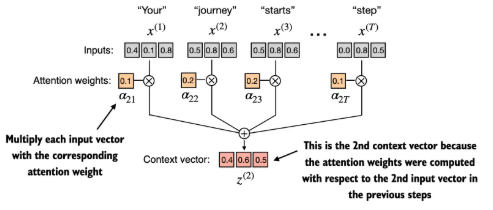

In [9]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


- Attention weights for all input tokens

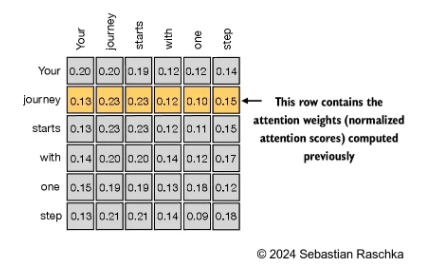

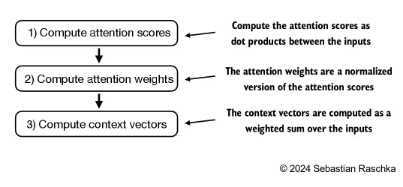

In [10]:
# step 1 : compute unnormalized attention score matrix

attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [11]:
# step 1 : attention scores using matrix multiplication - more efficient

attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [12]:
# step 2 : normalize each row

attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [13]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [14]:
# step 3 : to compute all context vectors

all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [15]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


# Self-Attention

- Self-attention mechanism is used in the original transformer architecture, the GPT models, and most other popular LLMs
- Self-attention mechanism is also called "scaled dot-product attention"

In [18]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [19]:
inputs.shape

torch.Size([6, 3])

In [20]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

# chose different input and output dimensions here

In [35]:
x_2.shape

torch.Size([3])

In [36]:
x_2

tensor([0.5500, 0.8700, 0.6600])

- The embedding dimensions of the input and the query vector
 can be the same or different, depending on the model's design and specific implementation
- In GPT models, the input and output dimensions are usually the same

In [26]:
torch.rand(3, 2)

tensor([[0.3821, 0.6605],
        [0.8536, 0.5932],
        [0.6367, 0.9826]])

In [28]:
torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=True)

Parameter containing:
tensor([[0.9268, 0.7388],
        [0.7179, 0.7058],
        [0.9156, 0.4340]], requires_grad=True)

In [29]:
torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

Parameter containing:
tensor([[0.0772, 0.3565],
        [0.1479, 0.5331],
        [0.4066, 0.2318]])

Weight matrices $ W_{q} $ , $ W_{k} $ , and $ W_{v} $ are used to project the embedded input tokens, $ x^{(i)} $ , into query, key, and value vectors via matrix multiplication:

- Query vector: $ q^{(i)} = x^{(i)}W_{q} $
- Key vector: $ k^{(i)} = x^{(i)}W_{k} $
- Value vector: $ v^{(i)} = x^{(i)}W_{v} $

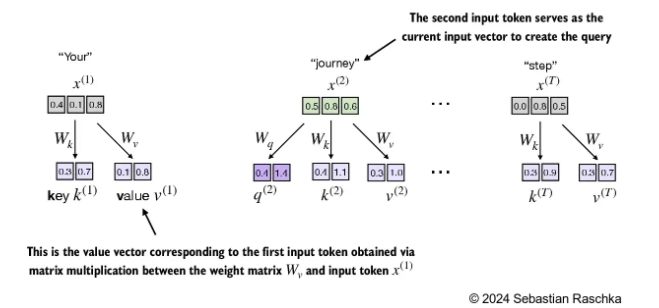

In [21]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

- here we are setting `requires_grad=False` to reduce clutter in the outputs but if we were to use the weight matrices for model training, we would set `requires_grad=True` to update these matrices during model training

- `torch.nn.Parameter()` is used to create a tensor that is treated as a model parameter. This means that during model training, PyTorch will automatically track gradients for this tensor and update its values based on the optimization algorithm used.

In [30]:
W_query, W_key, W_value

(Parameter containing:
 tensor([[0.2961, 0.5166],
         [0.2517, 0.6886],
         [0.0740, 0.8665]]),
 Parameter containing:
 tensor([[0.1366, 0.1025],
         [0.1841, 0.7264],
         [0.3153, 0.6871]]),
 Parameter containing:
 tensor([[0.0756, 0.1966],
         [0.3164, 0.4017],
         [0.1186, 0.8274]]))

In [31]:
W_query.shape, W_key.shape, W_value.shape

(torch.Size([3, 2]), torch.Size([3, 2]), torch.Size([3, 2]))

In [22]:
# compute query, key, and value vectors for 2nd input

query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [37]:
print(query_2.shape)

torch.Size([2])


In [32]:
print(key_2)

tensor([0.4433, 1.1419])


In [33]:
print(value_2)

tensor([0.3951, 1.0037])


In [23]:
keys = inputs @ W_key   # torch.Size([6, 3]) X torch.Size([3, 2])
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [24]:
keys

tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])

In [25]:
values

tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.1492, 0.3346],
        [0.3221, 0.7863]])

In [38]:
keys[1].shape

torch.Size([2])

In [34]:
# compute unnormalized attention scores by computing the dot product between the query and each key vector

# x_2 = inputs[1] =  tensor([0.5500, 0.8700, 0.6600]) i.e., torch.Size([3]) or 1 X 3 where inputs is 6 X 3 matrix
# W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) which is 3 X 2 matrix
# query_2 = x_2 @ W_query = tensor([0.4306, 1.4551]) , so it is a (1 X 3) (3 X 2) = 1 X 2 or torch.Size([2]) matrix

keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


- 6 attention scores for the given query vector for 6 inputs

In [39]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


- Now, we compute the attention weights (normalized attention scores that sum up to 1) using the softmax function we used earlier
- The difference to earlier is that we now scale the attention scores by dividing them by the square root of the embedding dimension, $ \sqrt{d_{k}} $ (i.e., d_k**0.5)

In [44]:
keys.shape[0]

6

In [40]:
keys.shape[1]

2

In [41]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [43]:
attn_weights_2.shape

torch.Size([6])

In [42]:
# compute context vector for input query vector 2

context_vec_2 = attn_weights_2 @ values # torch.Size([6]) X torch.Size([6, 2]) , i.e., (1X6)*(6X2)=(1X2)
print(context_vec_2)

tensor([0.3061, 0.8210])


## SelfAttention Class

In [45]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


- We can streamline the implementation above using PyTorch's Linear layers, which are equivalent to a matrix multiplication if we disable the bias units
- Another big advantage of using `nn.Linear` over our manual `nn.Parameter(torch.rand(...)` approach is that `nn.Linear` has a preferred weight initialization scheme, which leads to more stable model training

In [46]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


- `SelfAttention_v1` and `SelfAttention_v2` give different outputs because they use different initial weights for the weight matrices

# Causal Attention (Masked Attention)

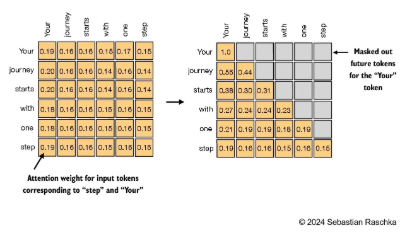

- In causal attention, the *attention weights* above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight

- Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions. this ensures that each next word prediction should only depend on the preceding words.

- To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text)

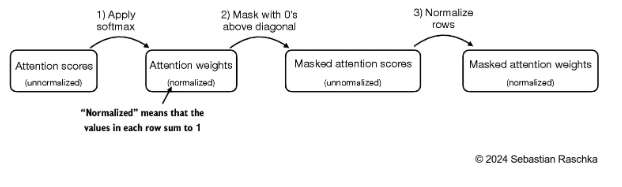

In [47]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the above Self-Attention

queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


- The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0

In [48]:
torch.ones(6, 6)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [53]:
torch.tril(torch.ones(6, 6))

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

In [54]:
attn_scores.shape, attn_scores.shape[0]

(torch.Size([6, 6]), 6)

In [51]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


- Then, we can multiply the attention weights with this mask to zero out the attention scores above the diagonal

In [55]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


- However, if the mask were applied after softmax, like above, it would disrupt the probability distribution created by softmax
- Softmax ensures that all output values sum to 1
- Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects

In [58]:
masked_simple.sum(dim=-1)

tensor([0.1921, 0.3700, 0.5357, 0.6775, 0.8415, 1.0000],
       grad_fn=<SumBackward1>)

In [59]:
masked_simple.sum(dim=-1, keepdim=True)

tensor([[0.1921],
        [0.3700],
        [0.5357],
        [0.6775],
        [0.8415],
        [1.0000]], grad_fn=<SumBackward1>)

In [56]:
# To make sure that the rows sum to 1, we can normalize the attention weights

row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


Instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function

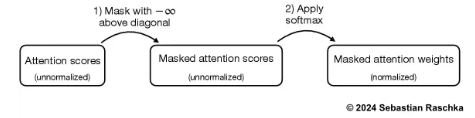

In [60]:
torch.triu(torch.ones(6, 6))

tensor([[1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [61]:
torch.triu(torch.ones(6, 6), diagonal=1)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [62]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [63]:
# apply softmax on the masked scores to calculate attention weights

attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### Masking additional attention weights with dropout

- Apply dropout to reduce overfitting during training
- Dropout can be applied in several places
  - for example, after computing the attention weights;
  - or after multiplying the attention weights with the value vectors
- Here, we will apply the dropout mask after computing the attention weights because it's more common

In [64]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


- If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2
- The scaling is calculated by the formula `1 / (1 - dropout_rate)`

In [65]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


## Causal Self-Attention Class

In [66]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


In [71]:
queries_test = batch @ W_query # torch.Size([2, 6, 2])
queries_test.shape, queries_test

(torch.Size([2, 6, 2]),
 tensor([[[0.2309, 1.0966],
          [0.4306, 1.4551],
          [0.4300, 1.4343],
          [0.2355, 0.7990],
          [0.2983, 0.6565],
          [0.2568, 1.0533]],
 
         [[0.2309, 1.0966],
          [0.4306, 1.4551],
          [0.4300, 1.4343],
          [0.2355, 0.7990],
          [0.2983, 0.6565],
          [0.2568, 1.0533]]]))

In [67]:
keys_test = batch @ W_key # torch.Size([2, 6, 2])
keys_test.shape, keys_test

(torch.Size([2, 6, 2]),
 tensor([[[0.3669, 0.7646],
          [0.4433, 1.1419],
          [0.4361, 1.1156],
          [0.2408, 0.6706],
          [0.1827, 0.3292],
          [0.3275, 0.9642]],
 
         [[0.3669, 0.7646],
          [0.4433, 1.1419],
          [0.4361, 1.1156],
          [0.2408, 0.6706],
          [0.1827, 0.3292],
          [0.3275, 0.9642]]]))

In [70]:
keys_test_T = keys_test.transpose(1, 2)
keys_test_T.shape, keys_test_T

(torch.Size([2, 2, 6]),
 tensor([[[0.3669, 0.4433, 0.4361, 0.2408, 0.1827, 0.3275],
          [0.7646, 1.1419, 1.1156, 0.6706, 0.3292, 0.9642]],
 
         [[0.3669, 0.4433, 0.4361, 0.2408, 0.1827, 0.3275],
          [0.7646, 1.1419, 1.1156, 0.6706, 0.3292, 0.9642]]]))

In [72]:
attn_scores_test = queries_test @ keys_test_T
attn_scores_test.shape, attn_scores_test

(torch.Size([2, 6, 6]),
 tensor([[[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
          [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
          [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
          [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
          [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
          [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]],
 
         [[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
          [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
          [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
          [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
          [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
          [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]]]))

Above calculation explanation :

inputs.shape = torch.Size([6, 3]) # prev

W_key.shape = torch.Size([3, 2])

keys = inputs @ W_key   # torch.Size([6, 2]) # prev

x = torch.Size([2, 6, 3]) # new batch input

W_key.shape = torch.Size([3, 2])

queries = x @ W_query   # torch.Size([2, 6, 2]) = torch.Size([2, 6, 3]) X torch.Size([3, 2])

keys = x @ W_key   # torch.Size([2, 6, 2]) = torch.Size([2, 6, 3]) X torch.Size([3, 2])

keys.transpose(1, 2) = torch.Size([2, 6, 2]).T = torch.Size([2, 2, 6)

attn_scores = queries @ keys.transpose(1, 2)  # torch.Size([2, 6, 6]) = torch.Size([2, 6, 2]) X torch.Size([2, 2, 6)

So, attention scores are for 6 X 6 contexts (6 words with each other) for the two 2 inputs.

context_vec = attn_weights @ values  # torch.Size([2, 6, 2] = torch.Size([2, 6, 6]) X torch.Size([2, 6, 2])

In [73]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        # For inputs where `num_tokens` exceeds `context_length`, this will result in errors
        # in the mask creation further below.
        # In practice, this is not a problem since the final LLM ensures that inputs
        # do not exceed `context_length` before reaching this forward method.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


`attn_scores.masked_fill_()` Inline code is used to apply a mask to the attention scores. The masked_fill_ method replaces elements in attn_scores with `-torch.inf` where the corresponding element in the mask is True. This effectively masks out certain attention scores, preventing the model from attending to those positions. The `_` at the end of `masked_fill_` indicates that this operation is performed in-place, modifying the attn_scores tensor directly. The slicing [:num_tokens, :num_tokens] is used to handle cases where the number of tokens in the input batch is smaller than the maximum context_length supported by the attention mechanism, ensuring the mask matches the actual dimensions of the attention scores.

***Note : dropout is only applied during training, not during inference***

## Multi-Head Attention Wrapper Class

In [74]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [75]:
torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In [77]:
batch.shape, batch.shape[1]

(torch.Size([2, 6, 3]), 6)

- In the implementation above, the embedding dimension is 4, because we d_out=2 as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4

## Multi-Head Attention Class with weight splits

- While the above is an intuitive and fully functional implementation of multi-head attention (wrapping the single-head attention CausalAttention implementation from earlier), we can write a stand-alone class called MultiHeadAttention to achieve the same

- We don't concatenate single attention heads for this stand-alone MultiHeadAttention class

- Instead, we create single W_query, W_key, and W_value weight matrices and then split those into individual matrices for each attention head

In [78]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`,
        # this will result in errors in the mask creation further below.
        # In practice, this is not a problem since the final LLM ensures that inputs
        # do not exceed `context_length` before reaching this forward method.

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        # .contiguous() method is used to ensure that the tensor's memory layout is contiguous, which is required by the view operation
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

 Added a linear projection layer (`self.out_proj`) to the `MultiHeadAttention` class above. This is simply a linear transformation that doesn't change the dimensions. It's a standard convention to use such a projection layer in LLM implementation, but it's not strictly necessary (recent research has shown that it can be removed without affecting the modeling performance

In [79]:
torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [84]:
# Simulating attn_scores = queries @ keys.transpose(2, 3) below

# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a.shape)
m = a @ a.transpose(2, 3)
print(m)
print(m.shape)

torch.Size([1, 2, 3, 4])
tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])
torch.Size([1, 2, 3, 3])


In [81]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


- There is a [torch.nn.MultiheadAttention](https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) class in PyTorch



**Overall Purpose of Reshaping and Transposing :**

The reshaping and transposing operations are essential for implementing multi-head attention efficiently using matrix multiplication.

- They allow for the parallel computation of attention scores and context vectors for all heads simultaneously within a batch.
- By rearranging the tensor dimensions, we can leverage highly optimized matrix multiplication routines provided by libraries like PyTorch.
- This avoids the need for explicit loops over attention heads, making the computation much faster, especially on hardware accelerators like GPUs.

### EXTRA

Compairing SelfAttention_v1 and SelfAttention_v2

In [85]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

d_in, d_out = 3, 2

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)

torch.manual_seed(123)
sa_v2 = SelfAttention_v2(d_in, d_out)

sa_v1.W_query = torch.nn.Parameter(sa_v2.W_query.weight.T)
sa_v1.W_key = torch.nn.Parameter(sa_v2.W_key.weight.T)
sa_v1.W_value = torch.nn.Parameter(sa_v2.W_value.weight.T)

In [86]:
sa_v1(inputs)

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)

In [87]:
sa_v2(inputs)

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)

Returning two-dimensional embedding vectors from MultiHeadAttentionWrapper() class

In [88]:
torch.manual_seed(123)

d_out = 1
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]],

        [[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


Initializing GPT-2 size attention modules

attention heads = 12

embedding size (d_in, d_out) = 768, 768

context_length = 1024

In [90]:
context_length = 1024
d_in, d_out = 768, 768
num_heads = 12

mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads)

In [91]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [92]:
count_parameters(mha)

2360064

which is **2.36 M**

- The GPT-2 model has **117M parameters** in total, but as we can see, most of its parameters are not in the multi-head attention module itself

The step-by-step calculation for above is:

- W_query (without bias): d_in * d_out = 768 * 768 = 589824.
- W_key (without bias): d_in * d_out = 768 * 768 = 589824.
- W_value (without bias): d_in * d_out = 768 * 768 = 589824.
- out_proj (with bias): d_out * d_out + d_out = 768 * 768 + 768 = 589824 + 768 = 590592.
- Sum the parameters from all four layers: 589824 + 589824 + 589824 + 590592 = 2360064.

The total number of parameters is indeed 2,360,064.

Total Parameters with bias :

- W_query: d_out * d_in + d_out = 768 * 768 + 768 = 589824 + 768 = 590592
- W_key: d_out * d_in + d_out = 768 * 768 + 768 = 589824 + 768 = 590592
- W_value: d_out * d_in + d_out = 768 * 768 + 768 = 589824 + 768 = 590592
- out_proj: d_out * d_out + d_out = 768 * 768 + 768 = 589824 + 768 = 590592
- Total parameters = 590592 + 590592 + 590592 + 590592 = 4 * 590592 = 2362368.